In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, Dataset,random_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from torchvision import models
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report


import os
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm
from torchvision import transforms
import cv2

In [3]:
def process_csv(csv_path, images_folder, output_base_folder, has_labels=False):
    df = pd.read_csv(csv_path)

    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    for index, row in df.iterrows():
        image_path = row['image_path']
        if has_labels:
            font = row.get('font', 'unknown_font')
            font_size = row.get('font_size', 'unknown_size')
            color = row.get('color', 'unknown_color').replace("#", "")

            class_folder = os.path.join(
                output_base_folder,
                color,
                font,
                f"size_{font_size}"
            )
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
        else:
            class_folder = output_base_folder

        source = os.path.join(images_folder, os.path.basename(image_path))
        destination = os.path.join(class_folder, os.path.basename(image_path))

        if os.path.exists(source):
            shutil.copy2(source, destination)
        else:
            print(f"File {os.path.basename(image_path)} does not exist in {images_folder}")

train_csv_path = 'C:/Users/ASUS/NextgenAI/train.csv'
test_csv_path = 'C:/Users/ASUS/NextgenAI/test.csv'
images_folder = 'C:/Users/ASUS/NextgenAI/images'

train_output_base_folder = 'C:/Users/ASUS/NextgenAI/train_test_pic/train_pic'
test_output_base_folder = 'C:/Users/ASUS/NextgenAI/train_test_pic/test_pic'

process_csv(train_csv_path, images_folder, train_output_base_folder, has_labels=True)
process_csv(test_csv_path, images_folder, test_output_base_folder, has_labels=False)

Number of classes: 4
Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


In [3]:
class Allwhite:
    def __init__(self, threshold=(200, 200, 200)):
            self.threshold = threshold
        
    def __call__(self, img):
            # Convert image to numpy array for pixel manipulation
            img_np = np.array(img)
            
            # Create a mask for pixels that are considered white noise or background
            mask = (img_np[..., 0] >= self.threshold[0]) & \
                (img_np[..., 1] >= self.threshold[1]) & \
                (img_np[..., 2] >= self.threshold[2])
            
            # Set those pixels to black (0, 0, 0)
            img_np[mask] = [255, 255, 255]
            
            # Convert back to PIL Image
            return Image.fromarray(img_np)
class BilateralFilter:
    def __init__(self, d=9, sigmaColor=75, sigmaSpace=75):
        self.d = d
        self.sigmaColor = sigmaColor
        self.sigmaSpace = sigmaSpace

    def __call__(self, img):
        # Convert the PIL Image to a NumPy array
        img_np = np.array(img)

        # Apply the bilateral filter using OpenCV
        filtered_img_np = cv2.bilateralFilter(img_np, self.d, self.sigmaColor, self.sigmaSpace)

        # Convert the filtered NumPy array back to a PIL Image
        filtered_img = Image.fromarray(filtered_img_np)

        return filtered_img


In [4]:
transform =transforms.Compose([ 
                    BilateralFilter(d=5, sigmaColor=60, sigmaSpace=60),   
                    Allwhite(),
                    transforms.RandomAffine(degrees=(0),
                                            translate=(0.05, 0.05),
                                            scale=(1.0, 1.0),
                                            shear=0),                 
                    transforms.CenterCrop((64, 512)),
                    transforms.ToTensor(),
    ])
root_dir = train_output_base_folder

In [5]:
class FontRecogdata(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        self.color_mapping = {'FF6666': 0, 
                              '0000FF': 1, 
                              'A020F0': 2, 
                              'DF3030': 3, 
                              '26E953': 4}
        self.font_mapping = {'Athiti-Regular': 0, 
                             'Sarabun-Regular': 1, 
                             'NotoSerifThai-Regular': 2,
                             'Kodchasan-Regular': 3, 
                             'Prompt-Regular': 4, 
                             'KhaosuayThin': 5, 
                             'FkBeautyRegular': 6}
        self.font_size_mapping = {18: 0, 
                                  20: 1, 
                                  22: 2, 
                                  24: 3, 
                                  26: 4, 
                                  28: 5}

        for color_dir in os.scandir(root_dir):
            if color_dir.is_dir():
                color = color_dir.name
                for font_dir in os.scandir(color_dir.path):
                    if font_dir.is_dir():
                        font = font_dir.name
                        for size_dir in os.scandir(font_dir.path):
                            if size_dir.is_dir() and size_dir.name.startswith("size_"):
                                font_size = int(size_dir.name.split('_')[1])
                                for file in os.scandir(size_dir.path):
                                    if file.is_file():
                                        self.data.append((file.path, font, font_size, color))

        print(f"Total data found: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, font, font_size, color = self.data[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Encode labels as tensors
        font_encoded = torch.tensor(self.font_mapping.get(font), dtype=torch.long)
        font_size_encoded = torch.tensor(self.font_size_mapping.get(font_size), dtype=torch.long)
        color_encoded = torch.tensor(self.color_mapping.get(color), dtype=torch.long)

        return image, color_encoded, font_encoded, font_size_encoded
dataset = FontRecogdata(root_dir=root_dir, transform=transform)

Total data found: 10080


In [6]:
### START CODE HERE ###
image, color_encoded, font_encoded ,font_size_encoded = next(iter(dataset))

image.shape, color_encoded.shape, font_encoded.shape,font_size_encoded.shape
### END CODE HERE ###

(torch.Size([3, 64, 512]), torch.Size([]), torch.Size([]), torch.Size([]))

In [7]:
dataset = FontRecogdata(root_dir=root_dir, transform=transform)

colormap = {v: k for k, v in dataset.color_mapping.items()}
fontmapping = {v: k for k, v in dataset.font_mapping.items()}
fontsizeM = {v: k for k, v in dataset.font_size_mapping.items()}

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

images, colors, fonts, font_sizes = next(iter(dataloader))

color_names = [colormap[int(color)] for color in colors]
font_names = [fontmapping[int(font)] for font in fonts]
font_size_names = [fontsizeM[int(font_size)] for font_size in font_sizes]

Total data found: 10080


In [8]:
def load_data(reverse=False, normalize=False, batch_size=32):
    root_dir = train_output_base_folder
        
    dataset = FontRecogdata(root_dir=root_dir, 
                            transform=transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [9]:
train_loader, test_loader = load_data(reverse=False, normalize=False, batch_size=32)

Total data found: 10080


In [10]:
def get_dataset_stats(loader):
    font_count = {}
    font_size_count = {}
    color_count = {}
    total_samples = 0

    colormap = {v: k for k, v in dataset.color_mapping.items()}
    fontmapping = {v: k for k, v in dataset.font_mapping.items()}
    fontsizeM = {v: k for k, v in dataset.font_size_mapping.items()}

    for batch in loader:
        images, colors, fonts, font_sizes = batch

        color_names = [colormap[int(color)] for color in colors]
        font_names = [fontmapping[int(font)] for font in fonts]
        font_size_names = [fontsizeM[int(font_size)] for font_size in font_sizes]

        for color in color_names:
            if color not in color_count:
                color_count[color] = 0
            color_count[color] += 1

        for font in font_names:
            if font not in font_count:
                font_count[font] = 0
            font_count[font] += 1

        for font_size in font_size_names:
            if font_size not in font_size_count:
                font_size_count[font_size] = 0
            font_size_count[font_size] += 1

        total_samples += len(images)

    return font_count, font_size_count, color_count, total_samples

In [11]:
train_font_count, train_font_size_count, train_color_count, train_total_samples = get_dataset_stats(train_loader)
test_font_count, test_font_size_count, test_color_count, test_total_samples = get_dataset_stats(test_loader)

print("📃Train Dataset:")
for font, count in train_font_count.items():
    print(f"\tNumber of images with font {font}: {count}")
for font_size, count in train_font_size_count.items():
    print(f"\tNumber of images with font size {font_size}: {count}")
for color, count in train_color_count.items():
    print(f"\tNumber of images with color {color}: {count}")
print(f"\tNumber of training samples: {train_total_samples}")

print("📃Test Dataset:")
for font, count in test_font_count.items():
    print(f"\tNumber of images with font {font}: {count}")
for font_size, count in test_font_size_count.items():
    print(f"\tNumber of images with font size {font_size}: {count}")
for color, count in test_color_count.items():
    print(f"\tNumber of images with color {color}: {count}")
print(f"\tNumber of testing samples: {test_total_samples}")

📃Train Dataset:
	Number of images with font KhaosuayThin: 1155
	Number of images with font Athiti-Regular: 1160
	Number of images with font Sarabun-Regular: 1150
	Number of images with font Kodchasan-Regular: 1145
	Number of images with font NotoSerifThai-Regular: 1135
	Number of images with font Prompt-Regular: 1145
	Number of images with font FkBeautyRegular: 1174
	Number of images with font size 18: 1351
	Number of images with font size 22: 1374
	Number of images with font size 24: 1312
	Number of images with font size 20: 1355
	Number of images with font size 26: 1338
	Number of images with font size 28: 1334
	Number of images with color A020F0: 1612
	Number of images with color DF3030: 1595
	Number of images with color FF6666: 1625
	Number of images with color 0000FF: 1620
	Number of images with color 26E953: 1612
	Number of training samples: 8064
📃Test Dataset:
	Number of images with font KhaosuayThin: 285
	Number of images with font Kodchasan-Regular: 295
	Number of images with 

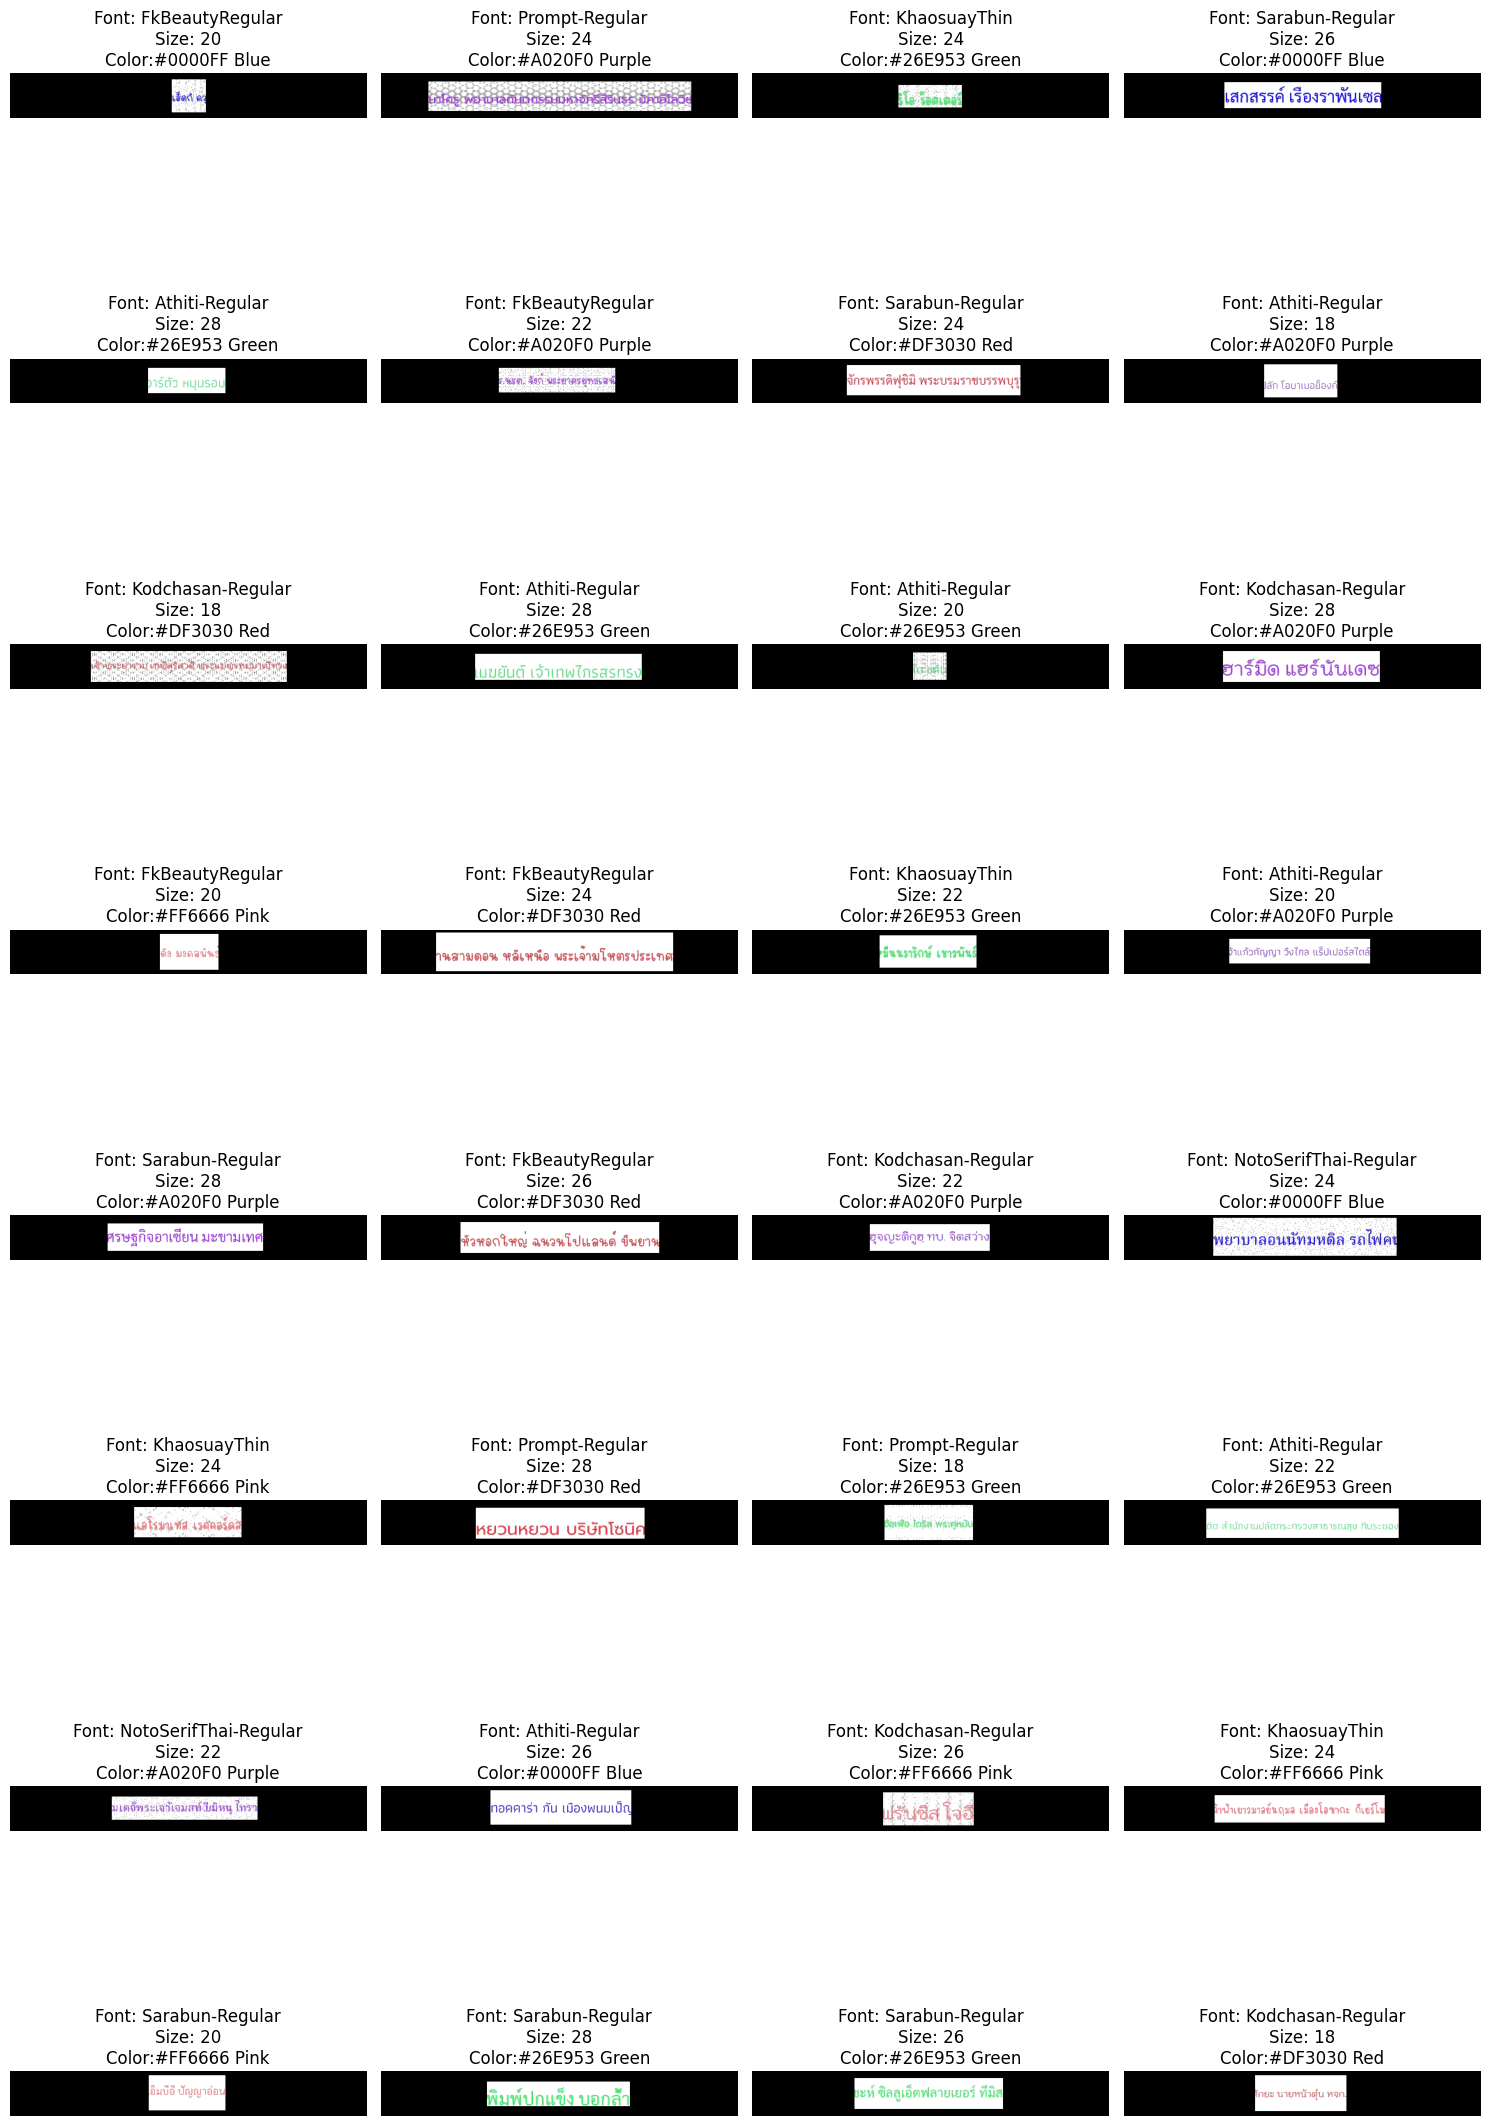

In [12]:
# TRAIN
color_name_map = {
    'FF6666': 'Pink',
    '0000FF': 'Blue',
    'A020F0': 'Purple',
    'DF3030': 'Red',
    '26E953': 'Green'
}
batch_size = 32
images, colors, fonts, font_sizes = next(iter(train_loader))

colormap = {v: k for k, v in dataset.color_mapping.items()}
fontmapping = {v: k for k, v in dataset.font_mapping.items()}
fontsizeM = {v: k for k, v in dataset.font_size_mapping.items()}

fig, axes = plt.subplots(8, 4, figsize=(15, 24))
axes = axes.flatten()

for idx, (img, color, font, font_size) in enumerate(zip(images[:batch_size], colors[:batch_size], fonts[:batch_size], font_sizes[:batch_size])):
    ax = axes[idx]

    img_np = img.permute(1, 2, 0).numpy()

    color_name = colormap[int(color)]
    font_name = fontmapping[int(font)]
    font_size_value = fontsizeM[int(font_size)]

    ax.imshow(img_np)
    ax.set_title(f"Font: {font_name}\nSize: {font_size_value}\nColor:#{color_name} {color_name_map[color_name]}")
    ax.axis('off')

for ax in axes[len(images[:batch_size]):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

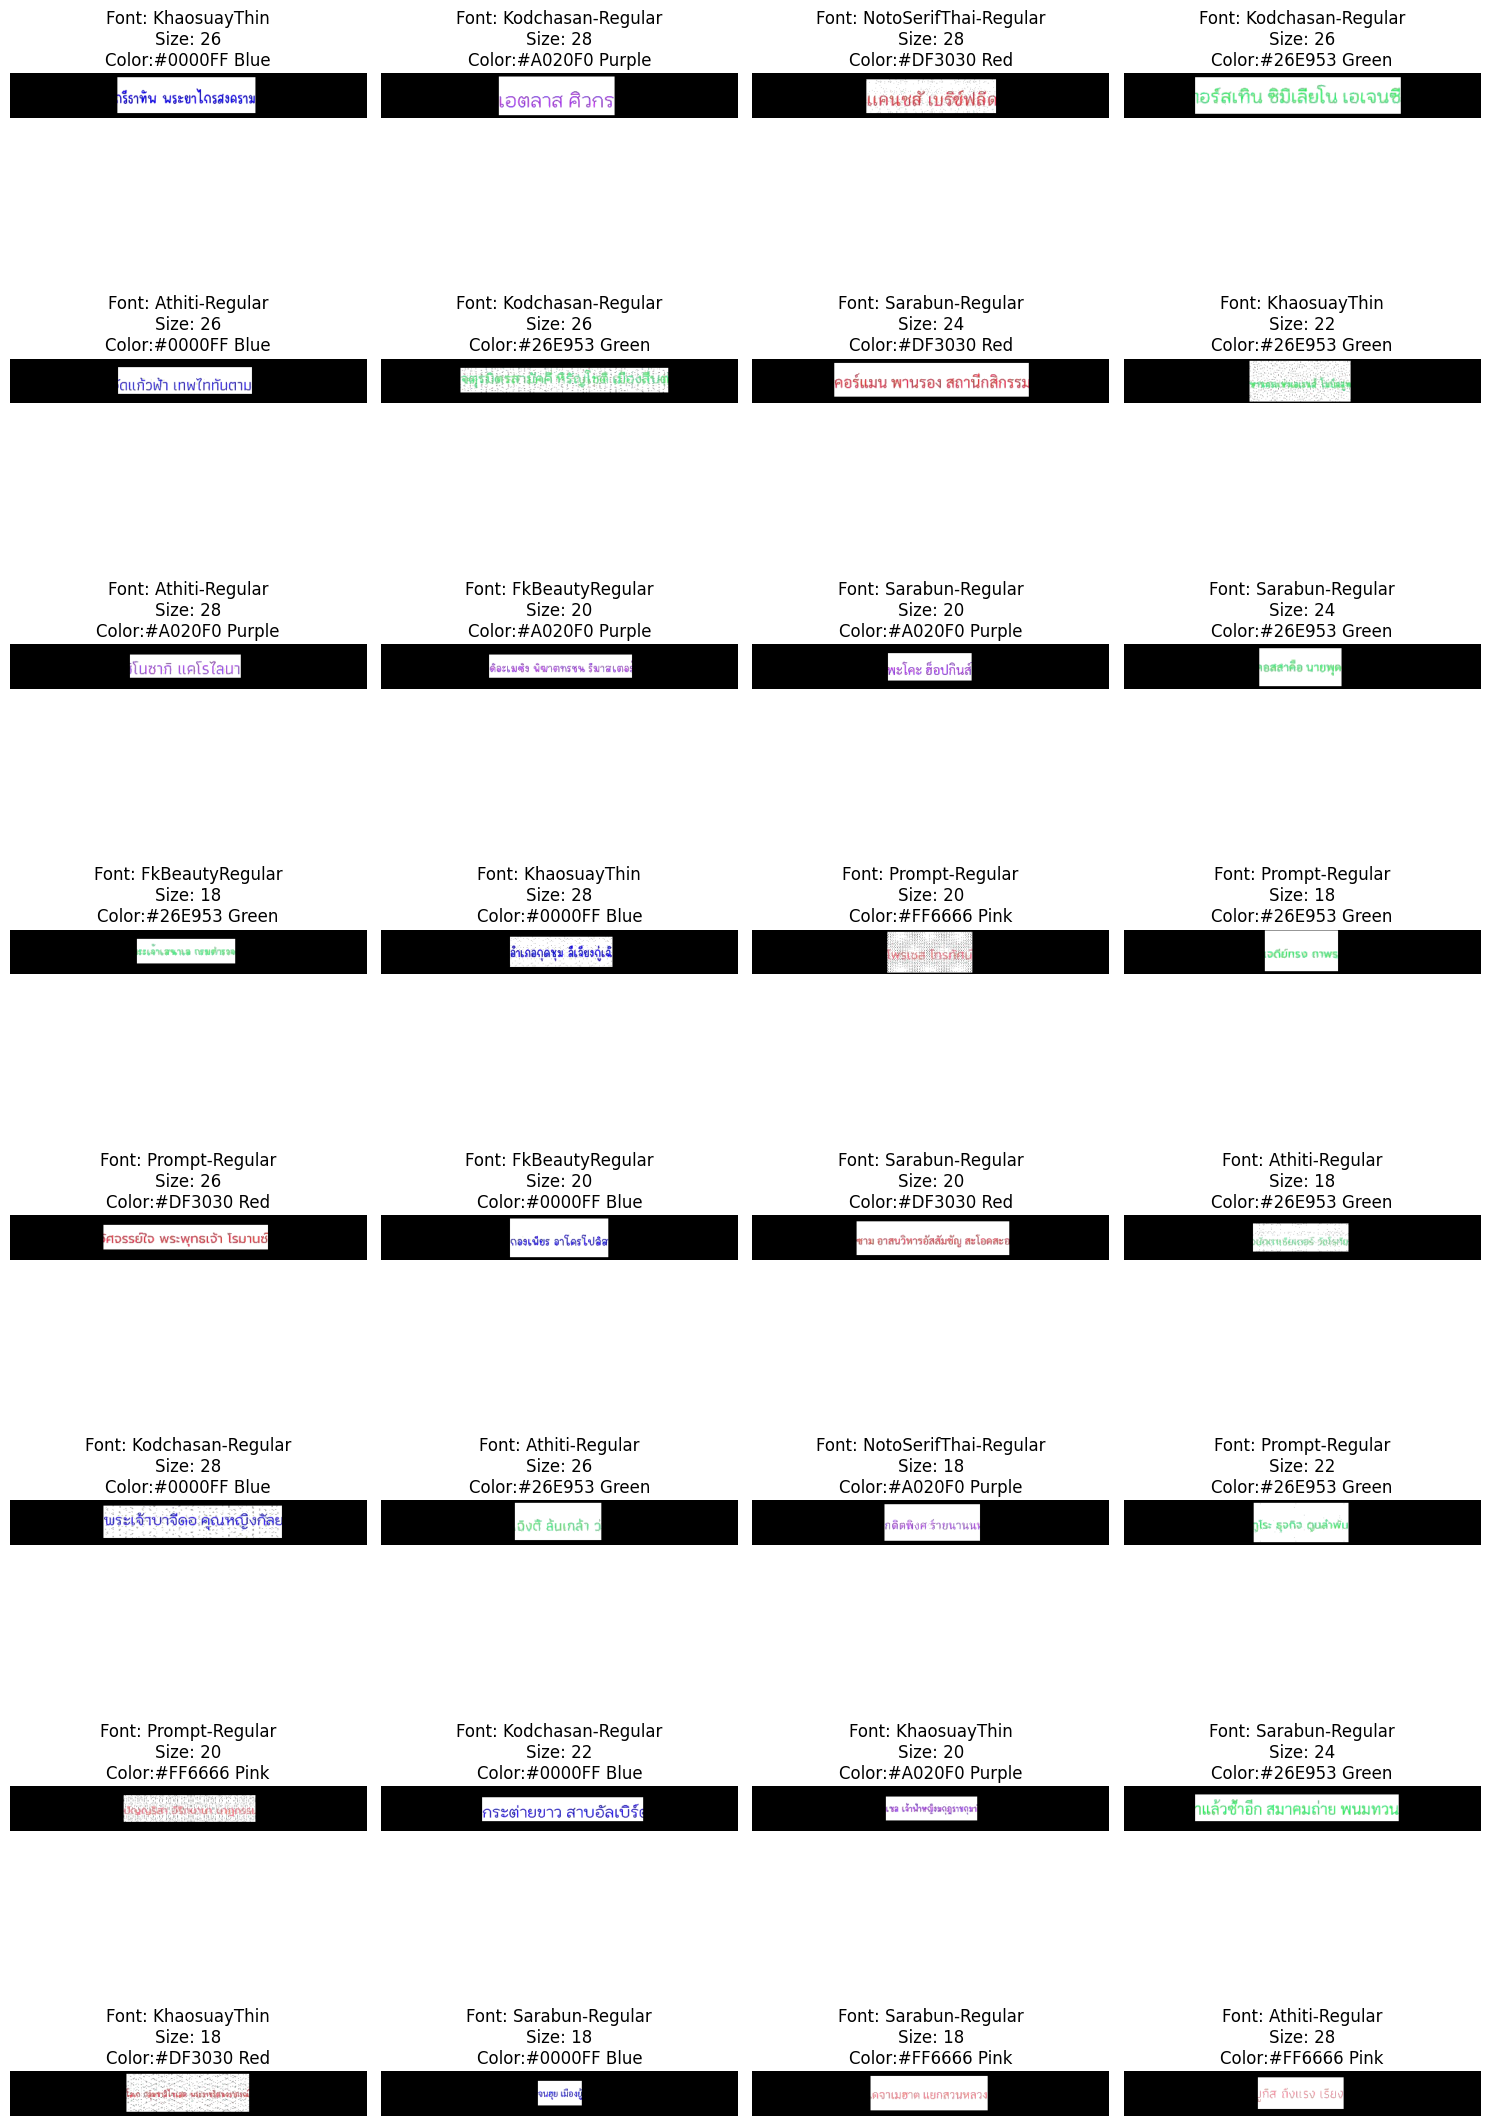

In [13]:
# TEST
batch_size = 32
images, colors, fonts, font_sizes = next(iter(test_loader))

colormap = {v: k for k, v in dataset.color_mapping.items()}
fontmapping = {v: k for k, v in dataset.font_mapping.items()}
fontsizeM = {v: k for k, v in dataset.font_size_mapping.items()}
fig, axes = plt.subplots(8, 4, figsize=(15, 24))
axes = axes.flatten()

for idx, (img, color, font, font_size) in enumerate(zip(images[:batch_size], colors[:batch_size], fonts[:batch_size], font_sizes[:batch_size])):
    ax = axes[idx]

    img_np = img.permute(1, 2, 0).numpy()

    color_name = colormap[int(color)]
    # color_hex = color_name_map[color_name]
    font_name = fontmapping[int(font)]
    font_size_value = fontsizeM[int(font_size)]

    ax.imshow(img_np)
    ax.set_title(f"Font: {font_name}\nSize: {font_size_value}\nColor:#{color_name} {color_name_map[color_name]}")
    ax.axis('off')

for ax in axes[len(images[:batch_size]):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [14]:
class CustomResNet(nn.Module):
    def __init__(self,
                 num_colors=5,
                 num_fonts=7,
                 num_sizes=6,
                 h_dims_color=[],
                 h_dims_font=[],
                 h_dims_size=[],
                 input_size=(3, 64, 512)):
        super(CustomResNet, self).__init__()

        self.resnet = models.resnet50(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = True

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity() 

        self.color_classifier = self._create_classifier(in_features, h_dims_color, num_colors)
        self.font_classifier = self._create_classifier(in_features, h_dims_font, num_fonts)
        self.size_classifier = self._create_classifier(in_features, h_dims_size, num_sizes)

    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []
        for hdim in h_dims:
            layers.append(nn.Linear(in_features, hdim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.25))
            in_features = hdim
        layers.append(nn.Linear(in_features, num_classes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)  

        color_output = self.color_classifier(x)
        font_output = self.font_classifier(x)
        size_output = self.size_classifier(x)

        return color_output, font_output, size_output

In [15]:
num_colors = 5
num_fonts = 7
num_sizes = 6

In [16]:
### START CODE HERE ###

# debuging model
dummy_input = torch.zeros(32, *(3,224,224))
model = CustomResNet(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128], h_dims_font=[1024, 512,256],h_dims_size=[1024,512,512])

### END CODE HERE ###

c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
color_output , font_output ,size_output  = model(dummy_input)
color_output.shape, font_output.shape,size_output.shape

(torch.Size([32, 5]), torch.Size([32, 7]), torch.Size([32, 6]))

In [18]:
best_score = 0.0

def train(model,optimizer,train_loader,test_loader,epochs=10,beta=2,checkpoint_path=None,device='cpu'):
    global best_score
    model = model.to(device)
    print("Training on",device)

    for epoch in range(epochs):
        
        model.train()
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        cross_entropy_loss = nn.CrossEntropyLoss()

        train_bar = tqdm(train_loader,
                         desc=f'Training Epoch [{epoch+1}/{epochs}]',
                         unit='batch')

        for batch_idx, (data, color_target, font_target, size_target) in enumerate(train_bar):
            data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

            optimizer.zero_grad()

            color_output, font_output, size_output = model(data)
            
            loss_color = cross_entropy_loss(color_output, color_target)
            loss_font = cross_entropy_loss(font_output, font_target)
            loss_size = cross_entropy_loss(size_output, size_target)

            loss = loss_color*0.5 + loss_font*1 + loss_size*1.5

            loss.backward()
            optimizer.step()

            train_bar.set_postfix(loss=loss.item())

        model.eval()
        
        scheduler.step()

        correct_color, correct_font, correct_size = 0, 0, 0
        test_loss_color, test_loss_font, test_loss_size = 0, 0, 0

        all_color_preds, all_color_targets = [], []
        all_font_preds, all_font_targets = [], []
        all_size_preds, all_size_targets = [], []

        with torch.no_grad():
            test_bar = tqdm(test_loader,
                            desc=f"Testing Epoch [{epoch+1}/{epochs}]",
                            unit='batch')

            for data, color_target, font_target, size_target in test_bar:
                data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

                color_output, font_output, size_output = model(data)

                test_loss_color += cross_entropy_loss(color_output, color_target).item()
                test_loss_font += cross_entropy_loss(font_output, font_target).item()
                test_loss_size += cross_entropy_loss(size_output, size_target).item()

                color_pred = color_output.argmax(dim=1, keepdim=True) 
                font_pred = font_output.argmax(dim=1, keepdim=True)
                size_pred = size_output.argmax(dim=1, keepdim=True)

                correct_color += color_pred.eq(color_target.view_as(color_pred)).sum().item()
                correct_font += font_pred.eq(font_target.view_as(font_pred)).sum().item()
                correct_size += size_pred.eq(size_target.view_as(size_pred)).sum().item()

                all_color_preds.extend(color_pred.cpu().numpy())
                all_color_targets.extend(color_target.cpu().numpy())
                all_font_preds.extend(font_pred.cpu().numpy())
                all_font_targets.extend(font_target.cpu().numpy())
                all_size_preds.extend(size_pred.cpu().numpy())
                all_size_targets.extend(size_target.cpu().numpy())

            test_loss_color /= len(test_loader.dataset)
            test_loss_font /= len(test_loader.dataset)
            test_loss_size /= len(test_loader.dataset)

            fbeta_color = fbeta_score(all_color_targets, all_color_preds, beta=beta, average='weighted')
            fbeta_font = fbeta_score(all_font_targets, all_font_preds, beta=beta, average='weighted')
            fbeta_size = fbeta_score(all_size_targets, all_size_preds, beta=beta, average='weighted')

            fbeta_total = (fbeta_font)*0.3 + (fbeta_color)*0.2 + (fbeta_size)*0.5

            print(f'Color loss:{test_loss_color:.4f} ||F1: {fbeta_color:.4f}🐻')
            print(f'Font loss: {test_loss_font:.4f} ||F1: {fbeta_font:.4f}🐻‍❄️')
            print(f'Size loss: {test_loss_size:.4f} ||F1: {fbeta_size:.4f}🐼')

            print(f'Real Score: {fbeta_total:.4f}')
            print(f'Best model: {fbeta_total:.4f} at epoch[{epoch+1}]')

            if fbeta_total > best_score:
                best_score = fbeta_total
                if checkpoint_path:
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f'Best model saved with Score: {fbeta_total:.4f} at epoch[{epoch+1}]🟥')


In [19]:
model = CustomResNet(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128], h_dims_font=[1024, 512,256],h_dims_size=[1024,512,512])
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=100,
      beta=2,
      checkpoint_path="C:/Users/ASUS/NextgenAI/Check_point.pth",
      device=device)

Training on cuda


Testing Epoch [1/100]:  97%|█████████▋| 61/63 [00:06<00:00,  9.46batch/s]


KeyboardInterrupt: 

In [20]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                print(layer_name)
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output.clone())
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

In [21]:
### START CODE HERE ###
targets = [name for name, _ in model.named_modules() if 'conv' in name or 'layer' in name]
targets
### END CODE HERE ###


['resnet.conv1',
 'resnet.layer1',
 'resnet.layer1.0',
 'resnet.layer1.0.conv1',
 'resnet.layer1.0.bn1',
 'resnet.layer1.0.conv2',
 'resnet.layer1.0.bn2',
 'resnet.layer1.0.conv3',
 'resnet.layer1.0.bn3',
 'resnet.layer1.0.relu',
 'resnet.layer1.0.downsample',
 'resnet.layer1.0.downsample.0',
 'resnet.layer1.0.downsample.1',
 'resnet.layer1.1',
 'resnet.layer1.1.conv1',
 'resnet.layer1.1.bn1',
 'resnet.layer1.1.conv2',
 'resnet.layer1.1.bn2',
 'resnet.layer1.1.conv3',
 'resnet.layer1.1.bn3',
 'resnet.layer1.1.relu',
 'resnet.layer1.2',
 'resnet.layer1.2.conv1',
 'resnet.layer1.2.bn1',
 'resnet.layer1.2.conv2',
 'resnet.layer1.2.bn2',
 'resnet.layer1.2.conv3',
 'resnet.layer1.2.bn3',
 'resnet.layer1.2.relu',
 'resnet.layer2',
 'resnet.layer2.0',
 'resnet.layer2.0.conv1',
 'resnet.layer2.0.bn1',
 'resnet.layer2.0.conv2',
 'resnet.layer2.0.bn2',
 'resnet.layer2.0.conv3',
 'resnet.layer2.0.bn3',
 'resnet.layer2.0.relu',
 'resnet.layer2.0.downsample',
 'resnet.layer2.0.downsample.0',
 'resn

In [22]:
### START CODE HERE ###
model.load_state_dict(torch.load("C:/Users/ASUS/NextgenAI/95/Check_point.pth"))
### END CODE HERE ###

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4856\620794764.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/Users/ASUS/NextgenAI/95/Ch

<All keys matched successfully>

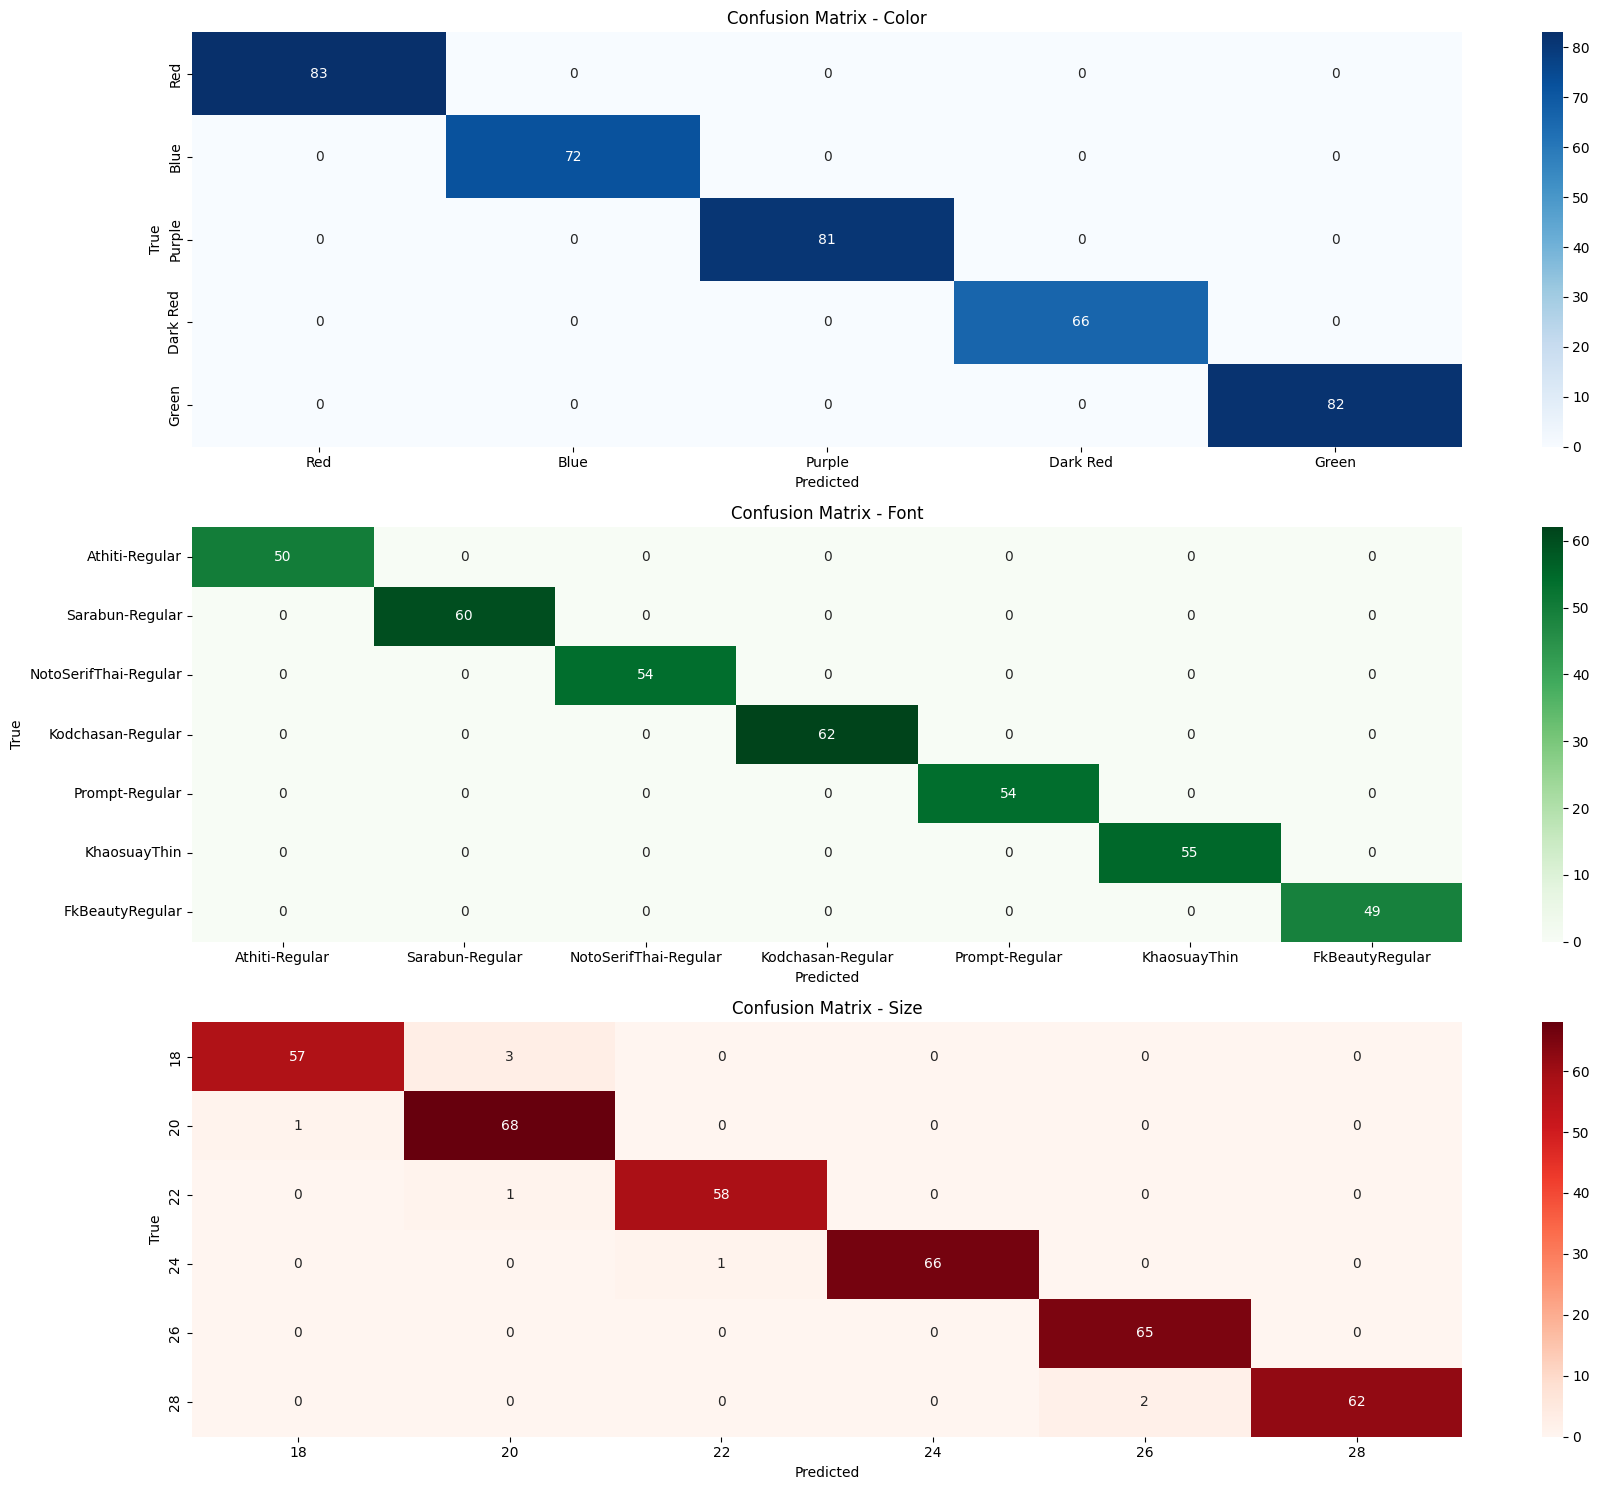

In [23]:
color_classes = ['Red', 'Blue', 'Purple', 'Dark Red', 'Green']
font_classes = ['Athiti-Regular', 'Sarabun-Regular', 'NotoSerifThai-Regular', 'Kodchasan-Regular', 'Prompt-Regular', 'KhaosuayThin', 'FkBeautyRegular']
size_classes = ['18', '20', '22', '24', '26', '28']

### START CODE HERE ###
model.eval()

# Initialize lists for predictions and targets
all_color_preds = []
all_font_preds = []
all_size_preds = []

all_color_targets = []
all_font_targets = []
all_size_targets = []

with torch.no_grad():
    num_batches = int(0.20 * len(test_loader))  # Use 20% of the test loader
    for batch_idx, (data, color_target, font_target, size_target) in enumerate(test_loader):
        if batch_idx >= num_batches:
            break  # Stop after processing 20% of the data
        
        data = data.to(device)
        color_target = color_target.to(device)
        font_target = font_target.to(device)
        size_target = size_target.to(device)

        # Get model predictions
        color_output, font_output, size_output = model(data)
        
        # Get the predicted classes
        color_pred = color_output.argmax(dim=1, keepdim=True)
        font_pred = font_output.argmax(dim=1, keepdim=True)
        size_pred = size_output.argmax(dim=1, keepdim=True)

        # Append predictions and targets to their respective lists
        all_color_preds.extend(color_pred.cpu().numpy())
        all_font_preds.extend(font_pred.cpu().numpy())
        all_size_preds.extend(size_pred.cpu().numpy())

        all_color_targets.extend(color_target.cpu().numpy())
        all_font_targets.extend(font_target.cpu().numpy())
        all_size_targets.extend(size_target.cpu().numpy())

# Calculate confusion matrices
cm_color = confusion_matrix(all_color_targets, all_color_preds)
cm_font = confusion_matrix(all_font_targets, all_font_preds)
cm_size = confusion_matrix(all_size_targets, all_size_preds)

# Plot confusion matrices
plt.figure(figsize=(18, 15))

plt.subplot(3, 1, 1)
sns.heatmap(cm_color, annot=True, fmt='d', cmap='Blues', xticklabels=color_classes, yticklabels=color_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Color')

plt.subplot(3, 1, 2)
sns.heatmap(cm_font, annot=True, fmt='d', cmap='Greens', xticklabels=font_classes, yticklabels=font_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Font')

plt.subplot(3, 1, 3)
sns.heatmap(cm_size, annot=True, fmt='d', cmap='Reds', xticklabels=size_classes, yticklabels=size_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Size')

plt.tight_layout()
plt.show()
### END CODE HERE ###


In [24]:
model = CustomResNet(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128], h_dims_font=[1024, 512,256],h_dims_size=[1024,512,512])
model.load_state_dict(torch.load("C:/Users/ASUS/NextgenAI/95/Check_point.pth"))

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

file_names, font_preds, size_preds, color_preds = [], [], [], []

submit_transform  = transform

csv_file = 'C:/Users/ASUS/NextgenAI/test.csv'
df = pd.read_csv(csv_file)

file_paths_from_csv = df.iloc[:, 0]

colormap = {v: k for k, v in dataset.color_mapping.items()}
fontmapping = {v: k for k, v in dataset.font_mapping.items()}
fontsizeM = {v: k for k, v in dataset.font_size_mapping.items()}

with torch.no_grad():
    submit_bar = tqdm(file_paths_from_csv, desc=f'📄 Submitting...', unit='image')
    for img_path in submit_bar:

        if not os.path.exists(img_path):
            print(f"File {img_path} does not exist.")
            continue
        image = Image.open(img_path).convert('RGB')
        image = submit_transform(image)
        image = image.unsqueeze(0).to(device)

        color_output, font_output, size_output = model(image)

        color_pred = color_output.argmax(dim=1, keepdim=True).item()
        color_preds.append(f"#{colormap[color_pred]}")

        font_pred = font_output.argmax(dim=1, keepdim=True).item()
        font_preds.append(fontmapping[font_pred])

        size_pred = size_output.argmax(dim=1, keepdim=True).item()
        size_preds.append(fontsizeM[size_pred])

        file_name = os.path.basename(img_path)
        file_names.append(f"images/{file_name}")

data = list(zip(file_names, font_preds, size_preds, color_preds))
submission_df = pd.DataFrame(data, columns=['image_path', 'font', 'font_size', 'color'])

output_path = "C:/Users/ASUS/NextgenAI/95/FixedWorkshop.csv"
submission_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")

c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4856\3521508784.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/py

File images/158b1476-5938-45dc-be90-9e50327c245d.jpg does not exist.
File images/da1628c5-6b4f-4ead-9514-e723355870e9.jpg does not exist.
File images/f75a8720-bdfb-465d-977a-1c208d23b2cc.jpg does not exist.
File images/ce67542f-d7d7-49ef-91f9-df686231154a.jpg does not exist.
File images/10df170a-ee18-4dbb-b8bc-0f5cd47ea861.jpg does not exist.
File images/ac996aba-034d-4754-a41a-26dcbb2b5a2f.jpg does not exist.
File images/4269af8e-5dba-4084-b9db-82f8f8b31993.jpg does not exist.
File images/1ef6b9da-4fd0-4a43-9780-b23dc5cd0e3a.jpg does not exist.
File images/94b2f2f7-37f8-4c34-a4eb-58a4df02ae2b.jpg does not exist.
File images/a031a923-1424-4d87-b8ab-e3da31ea2caa.jpg does not exist.
File images/612cac08-d54b-4256-95f5-1db3cf5ef558.jpg does not exist.
File images/046c1c28-14a4-435c-837a-888277849a27.jpg does not exist.
File images/a161d51b-c8c5-4cd9-b0b3-f2df24d263fa.jpg does not exist.
File images/1ec6a703-9090-42c2-9e6e-85b1ad71e52b.jpg does not exist.
File images/a0c35f6d-aeef-433f-ad7